In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
require(phyloseq)
require(reshape)
require(picante)
require(ape)
require(gtools)
require(ggplot2)
require(dplyr)

Loading required package: phyloseq
Loading required package: reshape
Loading required package: picante
Loading required package: ape
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0
Loading required package: nlme
Loading required package: gtools

Attaching package: ‘gtools’

The following object is masked from ‘package:permute’:

    permute

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged
physeq = prune_samples(sample_sums(physeq)>1500, physeq)

In [4]:
%%R
#ps = prune_samples(sample_data(physeq)$Month==2.5, physeq)
#ps = prune_samples(sample_data(ps)$Trtmt=="F"|sample_data(ps)$Trtmt=="Q", ps)
#ps = prune_samples(sample_data(ps)$Trtmt=="F", ps)
#ps = prune_samples(sample_data(ps)$Cosm==42, ps)
#ps = prune_samples(sample_data(ps)$Buff==1, ps)
ps

Error in withVisible({ : object 'ps' not found
In addition: Warning messages:
1: In asMethod(object) : NAs introduced by coercion
2: In asMethod(object) : NAs introduced by coercion
3: In asMethod(object) : NAs introduced by coercion
4: In asMethod(object) : NAs introduced by coercion
5: In asMethod(object) : NAs introduced by coercion
6: In asMethod(object) : NAs introduced by coercion
Error in withVisible({ : object 'ps' not found


In [5]:
%%R
#ps = physeq
#ps = subset_taxa(ps, Phylum=="Gemmatimonadetes")
#ps

NULL


In [6]:
%%R
ps=physeq
phy=phy_tree(ps)
samp=otu_table(ps)
# Need OTU table to have samples = rows

In [7]:
%%R
  samp <- t(samp)
# flips the OTU table back so now taxa are rows
  samp <- samp[mixedsort(rownames(samp)),]
# Gets the rownames
  sums <- subset(rowSums(samp), rowSums(samp) > 0)
# Chooses only the taxa with non-zero total counts
  samp <- samp[names(sums),]
# Redefines the OTU table so it's only those samples

In [8]:
%%R
phy = prune.sample(t(samp), phy)
# Cuts out any not included taxa from the phylogenetic tree as well
phy


Phylogenetic tree with 9161 tips and 9159 internal nodes.

Tip labels:
	43_439, 73_210971, 71_438806, 73.2_32914, 69_2370, 67.2_21506, ...
Node labels:
	, 0.826, 0.898, 0.817, 0.914, 0.993, ...

Unrooted; includes branch lengths.


In [9]:
%%R
samples = length(samp[1,])
taxa = length(samp[,1])
# gets the number of samples and OTUs we have

###My attempt at calculating the q distances

In [10]:
%%R
taxID = tax_table(physeq)
OTUs = colnames(otu_table(physeq))

In [11]:
%%R
Ztax = matrix(NA,nrow=length(OTUs),ncol=length(OTUs))
rownames(Ztax)=OTUs
colnames(Ztax)=OTUs

In [391]:
%%R
OTUsmini = OTUs[1:10]
Zmini = matrix(NA,nrow=10,ncol=10)
rownames(Zmini)=OTUsmini
colnames(Zmini)=OTUsmini

In [419]:
%%R
i = OTUsmini[1]
j = OTUsmini[2]

In [420]:
%%R
Zvalue = function(i,j){
    itax=c(taxID[i])
    jtax=c(taxID[j])
    ifelse(i==j,1,
        ifelse(itax[7]==jtax[7] & !is.na(itax[7]==jtax[7]),1,
              ifelse(itax[6]==jtax[6]& !is.na(itax[6]==jtax[6]),.83,
                    ifelse(itax[5]==jtax[5]& !is.na(itax[5]==jtax[5]),.67,
                          ifelse(itax[4]==jtax[4]& !is.na(itax[4]==jtax[4]),.5,
                                ifelse(itax[3]==jtax[3]& !is.na(itax[3]==jtax[3]),.33,
                                      ifelse(itax[2]==jtax[2]& !is.na(itax[2]==jtax[2]),.17,
                                            ifelse(itax[1]==jtax[1]& !is.na(itax[1]==jtax[1]),0,0))))))))
    }

In [423]:
%%R
for (i in OTUs){
    for (j in OTUs){
        Ztax[i,j] = Zvalue(i,j)
    }
}
# This would take 82 days on my computer to do the full list.
# outer(OTUsmini,OTUsmini,function(x,y) mapply(FUN=Zvalue,x,y))
# does the same thing, but not really faster.


Error while parsing the string.


In [69]:
%%R
Znaive = matrix(0,nrow=length(OTUs),ncol=length(OTUs))
rownames(Znaive)=OTUs
colnames(Znaive)=OTUs
Znaive[ row(Znaive) == col(Znaive) ] <- 1

In [27]:
%%R
Z = cophenetic.phylo(phy)
# This gives the distance between each pair of OTUs on the tree... can this be the Z matrix???
# computes the pairwise distances between the pairs of tips from a phylogenetic tree using its branch lengths
# Need to change this to Similarities, from Distances

In [28]:
%%R
maxZ = max(Z)
# The choice of max Z here does represent a choice of perspective on species similarity.
# We could also use the transformations Z = exp(-uZ), for a range of u values.
#Z = (1-Z/maxZ)
u=1
Z=exp(-u*Z)
# Because we want a Similarity matrix, not a DISsimilarity matrix!

In [29]:
%%R
relabund = t(apply(samp, 1, function(x) x/colSums(samp)))
# Populates the matrix with the relative abundance values for each OTU
# OTUs are rows, Samples are columns

In [30]:
%%R
### This takes maybe 5 minutes to calculate or so
Z = Z

nSamples = ncol(relabund)
# Calculates the number of samples we have
qvals = seq(0,50,5)
# sets up a sequence of q values from 1 to 5, increasing by 0.2
qDzp = matrix(NA,nrow=length(qvals),ncol=nSamples)
# Creates an empty matrix that we will populate, with the rows being the q values 
# and the columns being the samples
# We will fill this with the qDzp values for each q value, for each sample.
for (s in 1:nSamples){
    # We will calculate this for each sample
    ps = relabund[,s]
    # Gets a vector of the relative abundances of all the OTUs in this sample, s
    Zp = apply(Z,2,function(x) sum(x*ps))
    # Take the Z similarity matrix, and for each column(in order of OTUs),
        # multiply the values in that column by their relative abundance, and sum products
        # This gives a list for each OTU, of its Zp value
    qDzp[,s] = sapply(qvals, function(x) (sum(ps*(Zp^(x-1))))^(1/(1-x)))
    # Takes the Zp value, raises to q-1, multiplies by ps. Does this for each q value,
        # sums them, and raises to (1/(1-q))
}

In [31]:
%%R
d = data.frame(cbind(qvals,qDzp))
dcols = c("q",colnames(relabund))
colnames(d) = dcols
d = melt(d,id="q")

In [32]:
%%R
Trtmts = data.frame(sample_data(physeq))
Trtmts$ID = row.names(Trtmts)
colnames(d) = c("q","ID","qDzp")
d = merge(d,Trtmts,by="ID")

In [33]:
%%R
write.table(d, file = "qDzpAllMonths-c1.csv", append = FALSE, sep = ",")

In [34]:
%%R
d = read.csv("qDzpAllMonths-c1.csv")
d$q = as.numeric(d$q)
d$Month = as.factor(d$Month)
levels(d$Month) = c("1 month","2 months", "2.5 months")
levels(d$Trtmt) = c("Ferrihydrite","Heavy Fraction","Kaolinite","Quartz","Soil")
d$Trtmt = factor(d$Trtmt, levels=c("Ferrihydrite","Quartz","Soil","Heavy Fraction","Kaolinite"))

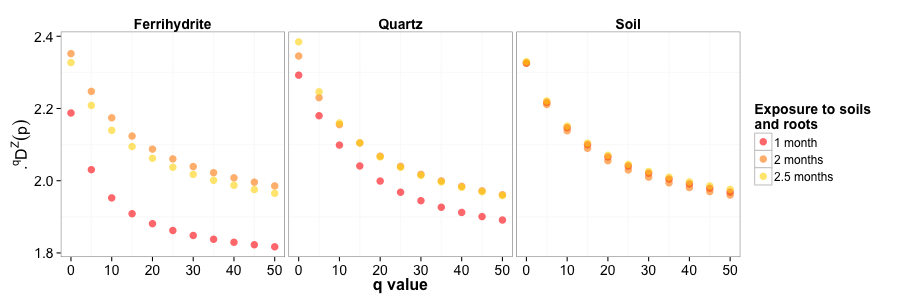

In [35]:
%%R -w 900 -h 300


d = d%>%
    filter(Trtmt=="Ferrihydrite"|Trtmt=="Quartz"|Trtmt=="Soil")

p = ggplot(d,aes(x=q,y=qDzp, colour=Month, stat="summary", fun.y="mean"))

#p = p + geom_boxplot(outlier.size=0.5)
#p = p + geom_point(size=2)

p = p + facet_wrap(~Trtmt)

stat_sum_single <- function(fun, geom="point") {
  stat_summary(fun.y=fun, geom=geom, size = 3.5, alpha=0.6)
}

p = p + stat_sum_single(mean)

p = p + theme_bw()
p = p + labs(y=parse(text='.^q*D^Z*(p)'), x="q value")
p = p + theme(axis.title.x = element_text(size = 16, face="bold"),
              axis.title.y = element_text(size = 16, face="bold"),
              axis.text = element_text(size=14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 12),
              panel.grid.major= element_blank(),
              strip.background = element_blank(),
              strip.text=element_text(size=14, face="bold"))
p = p + guides(colour = guide_legend(title="Exposure to soils\nand roots"))
#p = p + scale_colour_manual(values=c("skyblue3","darkorange","chartreuse4","red3","black","gold1"))
p = p + scale_colour_manual(values=c("red","darkorange","gold1"))

p

In [36]:
%%R
ggsave(filename="HillNumberMonths-c1.jpg", plot=p ,width=9, height=3)

In [37]:
%%R
d = read.csv("qDzpAllMonths-c1.csv")
d$q = as.factor(d$q)
d$Month = as.factor(d$Month)
levels(d$Month) = c("1 month","2 months", "2.5 months")
levels(d$Trtmt) = c("Ferrihydrite","Heavy Fraction","Kaolinite","Quartz","Soil")
d$Trtmt = factor(d$Trtmt, levels=c("Ferrihydrite","Quartz","Soil","Kaolinite","Heavy Fraction"))

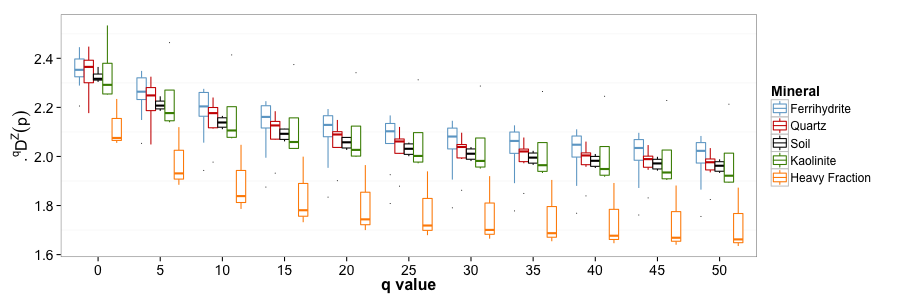

In [38]:
%%R -w 900 -h 300


d = d%>%
    filter(Month=="2 months")

p = ggplot(d,aes(x=q,y=qDzp, colour=Trtmt, stat="summary", fun.y="mean"))

p = p + geom_boxplot(outlier.size=0.5)
#p = p + geom_point(size=2)

#p = p + facet_wrap(~Trtmt, scales="free")

p = p + theme_bw()
p = p + labs(y=parse(text='.^q*D^Z*(p)'), x="q value")
p = p + theme(axis.title.x = element_text(size = 16, face="bold"),
              axis.title.y = element_text(size = 16, face="bold"),
              axis.text = element_text(size=14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 12),
              panel.grid.major= element_blank(),
              strip.background = element_blank(),
              strip.text=element_text(size=14, face="bold"))
p = p + guides(colour = guide_legend(title="Mineral"))
p = p + scale_colour_manual(values=c("skyblue3","red3","black","chartreuse4","darkorange","gold1"))
#p = p + scale_colour_manual(values=c("red","darkorange","gold1"))
#p = p + xlim(values=c(0,55))

p

In [39]:
%%R
ggsave(filename="HillNumber-c1.jpg", plot=p ,width=9, height=3)

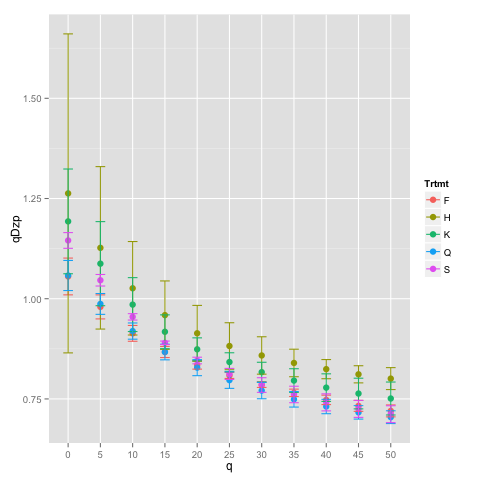

In [289]:
%%R
d$q = as.factor(d$q)
p = ggplot(d,aes(x=q,y=qDzp, colour=Trtmt, stat="summary", fun.y="mean"))

stat_sum_single <- function(fun, geom="point") {
  stat_summary(fun.y=fun, geom=geom, size = 3)
}

stat_sum_df <- function(fun, geom="errorbar") {
  stat_summary(fun.data=fun, geom=geom, width=0.3)
}

p = p + stat_sum_single(mean)
p = p + stat_sum_df("mean_cl_normal")

p

###Breaking down previous code

In [12]:
%%R
edge <- phy$edge[,2]
# Gets the beginning or ending node number for either tips or nodes..
Bnode = taxa + 1
# We want one more node than we have taxa (maybe affected by whether tree is rooted or not?)
Li = dist.nodes(phy)[1:taxa, Bnode]
# get the distance between all nodes from our tree, for each taxon, collecting the last node(how far from the root?)
Lb <- cbind(phy$edge[,2], phy$edge.length)
# Makes a table of the edge numbers and the edge lengths from our tree
Lb <- Lb[order(Lb[,1]),] 
# Just orders that.

In [13]:
%%R 
p=matrix(0,taxa,samples)
#creates empty matrix of correct dimensions (taxa (rows) x  samples (cols))

In [14]:
%%R
p = t(apply(samp, 1, function(x) x/colSums(samp)))
# Populates the matrix with the relative abundance values for each OTU

In [15]:
%%R
That=matrix(0,1,samples)
# Creates matrix of 0's with 1 row and the same number of columns as samples
That = t(as.matrix(apply(p,2,function(x) sum(Li*x))))
# From the relative abundance matrix, p, it calculates the sum of the product of Li(dist from root?) and p, by column.
# So, it takes each column of p (a list of relative abundances for a single sample)
# Then, it multiplies the relative abundances of each OTU by the distance of that OTU from the root.
# It adds all these up, getting a total number, and reports that back.
# There should be one number for each column (sample)

In [16]:
%%R


##########    This function returns the descendents of any internal node   #################################
  internal2tips.self = function (phy, int.node){
      # For a given node ID...
    Ntaxa = length(phy$tip.label)
    Nnode = phy$Nnode
    # Get the number of taxa and number of nodes
      if ((Ntaxa + Nnode - 1) != nrow(phy$edge)) {
          # if the sum of taxa (tips) and nodes is not equal to the number of edges in the tree, it's an error.
      print("tree structure error")
      break
    }
    if (mode(int.node) == "character"){
        # if the type of our node that was input is a character (not sure why this would happen...)
      nodes = which(phy$node.label == int.node) + Ntaxa
        # nodes are grabbed wherever they equal the node we specified, and we add the total number of taxa
    }
      else nodes = int.node
          # We select the node that we input
    tips = c()
          # Creates a tips variable
    repeat {
      nodes = phy$edge[which(phy$edge[, 1] %in% nodes), 2]
        # nodes is redefined as the end of the edges that were present in nodes
      if (length(nodes) == 0)
        break
      tips = c(tips, nodes)
          # Tips is defined as a string of the tips and the nodes, as defined above
    }
    tips = tips[tips <= Ntaxa]
        # We cut off any tips value if it went beyond the number of taxa we have
    if( int.node <= Ntaxa & length(tips) == 0 ){
        #if our input value was less than the Ntaxa AND the we had no tips present
      tips = int.node
        # tips is just set to whatever our node input was
    }
    tips = phy$tip.label[tips]
        # We return the names of all the taxa that fit our above criteria
    return(tips)
  }
  # Basically, this takes a node, and figures out which taxa are attached to (descended from) it

In [17]:
%%R

############################################################################################################
#####This builds the Z matrix from your phylogeny ######################################################
  ########################################################
  
S <- rep(1:length(phy$tip.label))
# Creates a list of numbers the length of the number of taxa we have
sp <- matrix(NA, nrow = length(S) + 1, ncol = length(edge) + 1)
# Creates a matrix of NA values, of dimensions the number of taxa in rows, and the number of branch bits in columns

In [46]:
%%R
sp[1,-1] <- sort(edge)
# Fills row 1 of the sp matrix with the edge numbers, shifting by 1
sp[-1,1] <- S
# Fills the column 1 of the sp matrix with the OTU numbers, shifting by 1
edges <- sp[1,]
# Creates the edges variable representing the first row (edge numbers) of the sp matrix

### This is a little slow... 5:29 to 5:35 for 4 samples full spp.
Started at 1:33 for full set 2.5 months... expect finished by 2:30PM

In [20]:
%%R
Nedges = edges[2:ncol(sp)]
# Pulls out the number of edges again (previously edge)
Nspecies = sp[2:nrow(sp)]
# Pulls out the number of species again (previously S)
funcTips = function(x) {internal2tips.self(phy,x)}
# Defines the function as using the phy tree with variable x to calculate internal2tips.self
# basically, it gets all the taxa that were related to the node ID that was input
funcList = lapply(Nedges,funcTips)
# We input, serially, the node IDs, and figure out what all their related OTUs are.
tmp = t(outer(funcList,Nspecies,function(x,y) mapply(function(x,y) ifelse(y %in% x,1,0),x,y)))
# Creates a matrix of all the species and whether or not they are "descendants" of a given node.
sp[2:nrow(sp),2:ncol(sp)]=tmp
# Fills our sp matrix with these values
write.table(sp, file = "sp1.csv", append = FALSE, sep = ",")
# Just saves the table because it's long to calculate, so we can jump to it faster for future re-runs

In [18]:
%%R
sp = read.csv("sp1.csv")
# sp will be a matrix of OTUs by nodes, and whether or not they are present

In [ ]:
%%R
  hs <- sp[-1,-1]
# Gets sp without the first row and without the first column.
  colnames(hs) <-sort(edge)
  rownames(hs) <- S
# Assigns the species names and edge names to hs, which say whether a given species is a "descendant" of each node
  hs <- melt(hs, varnames = c("species", "branch"))
# Reshapes the hs table so we have each possible node and each possible species combo listed
hs

In [ ]:
%%R
  for (k in 1:samples){
    hs[,k + 3] <- rep(p[,k], length(edge))
      # adds a column to our new hs table, for each sample, reporting the relative abundance of each OTU for each sample
          # the number of times that there are edges.
          # So, we should have a table with OTUs, with the presence/absence for each branch/node,
            # and then the relative abundance of the OTUs in each sample...
  }


In [ ]:
%%R
hs[1:40,]

In [ ]:
%%R

hs$Li <- rep(Li, length(edge))
# Adds a column with all the Li values (distances from root for each OTU)
hs <- hs[order(hs$species), ]
# Order by OTU
hs$Lb <- rep(Lb[,2], length(phy$tip.label))
# Adds Lb column, which is edges
hs <- (subset(hs, hs$value != 0))
# Select hs wherever the value column is not 0
hs <- hs[order(hs$species, hs$branch), ]

write.table(hs, file = "hs.csv", append = FALSE, sep = ",")
# Finally, we should end up with a table with the following columns
# OTU (listed repeatedly), Presence in branch from this node (0/1), Distance from root, node name

In [ ]:
%%R
hs = read.csv("../../../../../../../../../../Volumes/Seagate\ Backup\ Plus\ Drive/SeqData16S/hs.csv")

In [ ]:
%%R
hs[2,2]

### Below is the longest step - from 5:38 to .... for full spp 4 samples. Above takes ~4 min for same
Taking list out of the outer function sped it up.

In [ ]:
%%R
Z <- matrix(NA, nrow(hs), nrow(hs))
colnames(Z) <- hs$species
rownames(Z) <- hs$branch

In [ ]:
%%R
Nbranch = hs$branch[1:length(hs$branch)]
Nspecies = hs$species[1:length(hs$species)]
funcTips = function(x) {internal2tips.self(phy,x)}
funcList = lapply(Nbranch,funcTips)
Z = outer(funcList, Nspecies, function(x,y)mapply(function(x,y) ifelse(y %in% x, That/Li[y], 0),x,y))
# If a species is found stemming from a given node,
    # report the That value divided by the distance from the root for this OTU 
        # sum of distances of each OTU from this OTU divided by distance of this OTU
write.table(Z, file = "ZTable.csv", append = FALSE, sep = ",")

In [ ]:
%%R

pi <- matrix(0, ncol(Z), samples)
  for (k in 1:samples){
pi[,k] <- (hs$Lb/That[,k])*hs[,k+3]
}
write.table(pi, file = "pi.csv", append = FALSE, sep = ",")

In [ ]:
%%R

lenq <- 50
qq <- seq(length = lenq, from  = 0, by = .11)

# Initialise the Zp matrix to zero
Zp=matrix(0,ncol(Z), samples)

In [ ]:
%%R

# Compute Zp
for (k in 1:samples) {
for (i in 1:ncol(Z)){
  for (j in 1:ncol(Z)){
    Zp[i,k]<-Zp[i,k]+Z[i,j]*pi[j,k]
  }
}}
write.table(Zp, file = "Zp.csv", append = FALSE, sep = ",")

In [ ]:
%%R
  
# Initialise the Diversity matrix to zero
Dqz = matrix(0, lenq ,samples)

#  Loop to calculate the diversity Dqz for each value of q (iq) and each sample (k)

for (k in 1:samples) {

for (iq in 1:lenq)  {
  q<-qq[iq];

  for (zpi in 1:length(Zp[,k])){
    if (Zp[zpi,k]>0)(
      Dqz[iq,k]<-Dqz[iq,k]+ pi[zpi,k]*(Zp[zpi,k])^(q-1))
  }

  Dqz[iq,k] <- Dqz[iq,k]^(1/(1-q));
}
}
write.table(Dqz, file = "Dqz.csv", append = FALSE, sep = ",")

### Stop here - original code

In [ ]:
%%R
#######################################################    DONE!!!! ##############################################
#Here's an example:

#data(phylocom)
#samp = phylocom$sample
#phy = prune.sample(samp, phylocom$phylo)

samp = OTUs
phy = Tree

the.answer <- Phylo.Z(phy = phy, samp = samp)

In [ ]:
%%R
#From https://gist.github.com/darmitage/2649763
############Here's a function that calculates Hill number diversity using a phylogeny from the Leinster and Cobbold (2012) paper

#Requires a phylogeny with tip labels and a community matrix (rows = samples, columns = species)
Phylo.Z <- function(phy,samp){

#packages required for this to work:
  require(reshape)
  require(picante)
  require(ape)
  require(gtools)
  
  phy <- prune.sample(samp,phy)
  samp <- t(samp)
  samp <- samp[mixedsort(rownames(samp)),]
  sums <- subset(rowSums(samp), rowSums(samp) > 0)
  samp <- samp[names(sums),]
  samples = length(samp[1,])
  taxa = length(samp[,1])
  phy$tip.label <- rep(1:length(phy$tip.label))
  edge <- phy$edge[,2]
    Bnode = taxa + 1
  Li = t(t(dist.nodes(phy)[1:taxa, Bnode]))
  Lb <- cbind(phy$edge[,2], phy$edge.length)
  Lb <- Lb[order(Lb[,1]),] 
  
  p=matrix(0,taxa,samples)
  
  for (k in 1:samples){
    p[,k]<-samp[,k]/sum(samp[,k])
  }
  
  That=matrix(0,1,samples)
  for (k in 1:samples){
    That[,k] <-sum(Li * p[,k])
  }

##########    This function returns the descendents of any internal node   #################################
  internal2tips.self = function (phy, int.node){
    #require(picante); require(ape)
    Ntaxa = length(phy$tip.label)
    Nnode = phy$Nnode
    if ((Ntaxa + Nnode - 1) != nrow(phy$edge)) {
      print("tree structure error")
      break
    }
    if (mode(int.node) == "character"){
      nodes = which(phy$node.label == int.node) + Ntaxa
    }else nodes = int.node
    tips = c()
    repeat {
      nodes = phy$edge[which(phy$edge[, 1] %in% nodes), 2]
      if (length(nodes) == 0)
        break
      tips = c(tips, nodes)
    }
    tips = tips[tips <= Ntaxa]
    if( int.node <= Ntaxa & length(tips) == 0 ){
      tips = int.node
    }
    tips = phy$tip.label[tips]
    return(tips)
  }
  
############################################################################################################
#####This builds the Z matrix from your phylogeny ######################################################
  ########################################################
  
  S <- rep(1:length(phy$tip.label))
  sp <- matrix(NA, nrow = length(S) + 1, ncol = length(edge) + 1)
  sp[1,-1] <- sort(edge)
  sp[-1,1] <- S
  edges <- sp[1,]
  
  for (i in (2:ncol(sp))) {
    branch <- internal2tips.self(phy,edges[i])
    
    for (j in (2:nrow(sp))){
      sp[j,i] <- ifelse(sp[j,1] %in% branch, 1, 0)
    }
  }
  
  hs <- sp[-1,-1]
  colnames(hs) <-sort(edge)
  rownames(hs) <- S
  hs <- melt(hs, varnames = c("species", "branch"))
  for (k in 1:samples){
    hs[,k + 3] <- rep(p[,k], length(edge))
  }

  hs$Li <- rep(Li, length(edge))
  hs <- hs[order(hs$species), ]
  hs$Lb <- rep(Lb[,2], length(phy$tip.label))
  hs <- (subset(hs, hs$value != 0))
  hs <- hs[order(hs$species, hs$branch), ]
  
  
  
  Z <- matrix(NA, nrow(hs), nrow(hs))
  colnames(Z) <- hs$species
  rownames(Z) <- hs$branch
  
  for(i in 1:length(hs$branch)){
    for(j in 1:length(hs$species)){
      branch <- internal2tips.self(phy,hs$branch[i])
      
      Z[i,j] <- ifelse(hs$species[j] %in% branch, That/Li[hs$species[j]], 0)
    }
  }

pi <- matrix(0, ncol(Z), samples)
  for (k in 1:samples){
pi[,k] <- (hs$Lb/That[,k])*hs[,k+3]
}
  
  lenq <- 50
  qq <- seq(length = lenq, from  = 0, by = .11)
  
  # Initialise the Zp matrix to zero
  Zp=matrix(0,ncol(Z), samples)
  
  
  # Compute Zp
  for (k in 1:samples) {
    for (i in 1:ncol(Z)){
      for (j in 1:ncol(Z)){
        Zp[i,k]<-Zp[i,k]+Z[i,j]*pi[j,k]
      }
    }}

  
  
  # Initialise the Diversity matrix to zero
  Dqz = matrix(0, lenq ,samples)
  
  #  Loop to calculate the diversity Dqz for each value of q (iq) and each sample (k)
  
  for (k in 1:samples) {
    
    for (iq in 1:lenq)  {
      q<-qq[iq];
      
      for (zpi in 1:length(Zp[,k])){
        if (Zp[zpi,k]>0)(
          Dqz[iq,k]<-Dqz[iq,k]+ pi[zpi,k]*(Zp[zpi,k])^(q-1))
      }
      
      Dqz[iq,k] <- Dqz[iq,k]^(1/(1-q));
    }
  }
  
  return(Dqz)
}


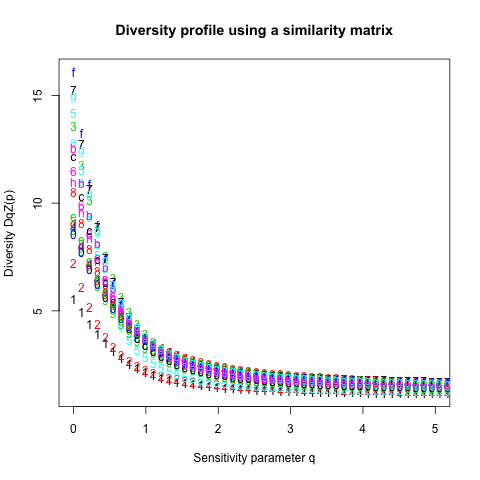

In [89]:
%%R

colnames(Dqz)=colnames(samp)
# Plot the diversity profiles for all the samples on the same graph.
  matplot(qq,Dqz, ylim = c(min(Dqz),max(Dqz)), xlim = c(0,5),
          xlab="Sensitivity parameter q",
          ylab="Diversity DqZ(p)",
          main="Diversity profile using a similarity matrix"
          )
 

In [91]:
%%R
write.table(Dqz, file = "Dqz.csv", append = FALSE, sep = ",")